## Load data

In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import librosa
import librosa.display

plt.style.use('seaborn-v0_8-paper')

In [2]:
def load_data(phase, path = os.getcwd()):
    if phase == "dev":
        data_path = os.path.join("dsl_data", "development.csv")
    elif phase == "eval":
        data_path = os.path.join("dsl_data", "evaluation.csv")
    else:
        raise Exception(f"Error - phase '{phase}' not recognised.")

    df = pd.read_csv(os.path.join(path, data_path))

    rates = []
    datas = []
    for wav_path in df["path"]:
        audio, sample_rate = librosa.load(os.path.join(path, wav_path), res_type="kaiser_fast")
        rates.append(sample_rate)
        datas.append(audio)
    df["rate"] = rates
    df["data"] = datas

    if phase == "dev":
        df["intent"] = df["action"] + df["object"]
        df.drop(columns=["action", "object"], inplace=True)
    
    return df

In [3]:
df_dev  = load_data("dev")
df_eval = load_data("eval")

## Preprocessing

Exclusively for the preprocessing phase, we will concat the development and evaluation data set. In this way we can modify the variables only once and study the distribution of the data in more detail.

In [4]:
df = pd.concat([df_dev, df_eval], sort=False, ignore_index=True)
df_dev.shape, df_eval.shape, df.shape

((9854, 11), (1455, 10), (11309, 11))

check for missing values

In [5]:
pd.DataFrame({"Type": df.dtypes, "NaN": df.isna().any(axis=0), "# unique": df[df.columns.drop("data")].nunique()})

,Type,NaN,# unique
Current language used for work/school,object,False,4.0
First Language spoken,object,False,5.0
Id,int64,False,9854.0
Self-reported fluency level,object,False,4.0
ageRange,object,False,3.0
data,object,False,NaN
gender,object,False,2.0
intent,object,True,7.0
path,object,False,11309.0
rate,int64,False,1.0


Just `intent`, but it is because `df_eval` does not have the label column

Let's do some plots to study the distributions of the variables

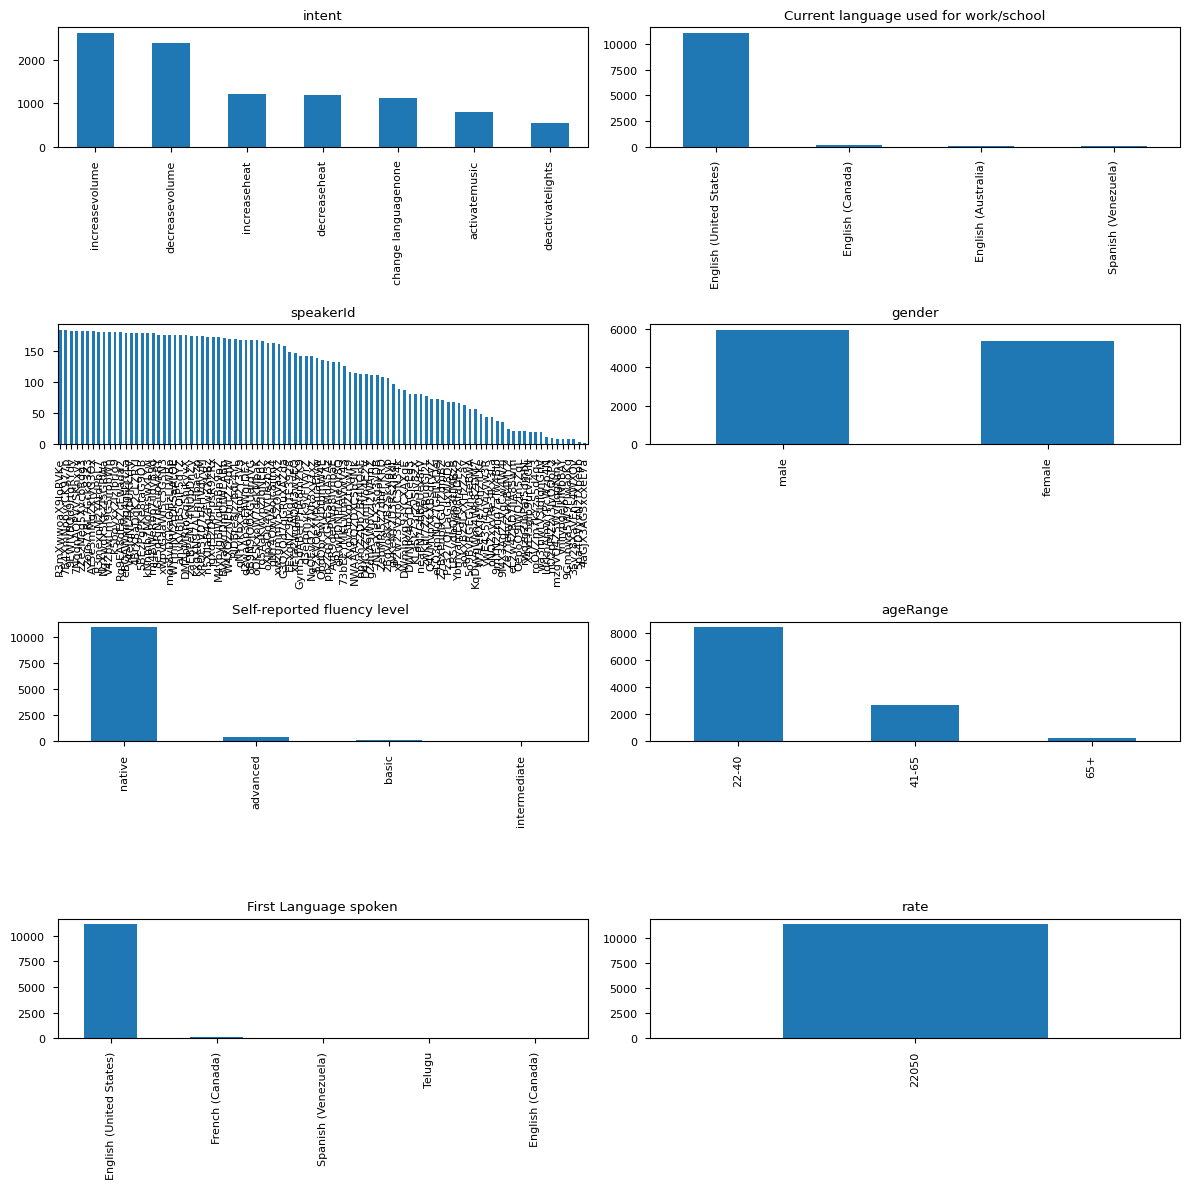

In [6]:
cols = ["intent", "speakerId", "Self-reported fluency level ", "First Language spoken", "Current language used for work/school", "gender", "ageRange", "rate"]
fig, ax = plt.subplots(4, 2, figsize=(12, 12))
for idx, c in enumerate(cols):
    if idx < 4:
        j = 0
    else:
        j = 1
    df[c].value_counts().plot.bar(ax=ax[idx%4][j])
    ax[idx%4][j].set_title(c)
plt.tight_layout()
plt.show()

We can see that there are two sample rates, we could resample to have only 22050 since it is better.

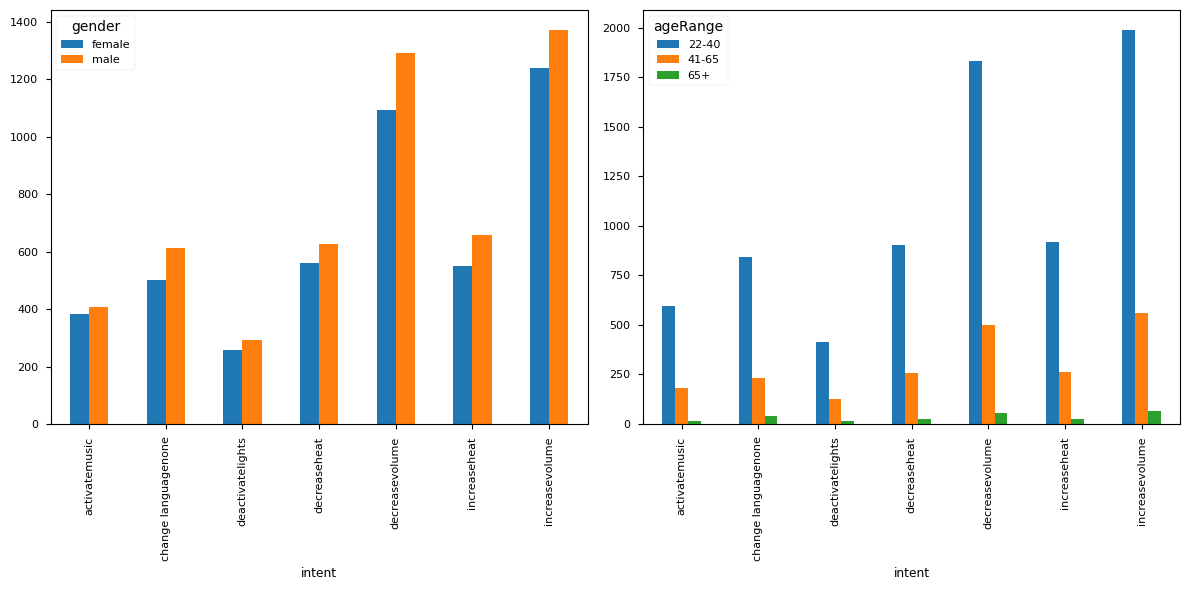

In [7]:
cols = ["gender", "ageRange"]
fig, ax = plt.subplots(1, 2, figsize=(12, 6))
for i, c in enumerate(cols):
    table = pd.pivot_table(df, columns=[c], index=["intent"], values="Id", aggfunc="count")
    table.plot(kind = "bar", ax=ax[i])
plt.tight_layout()
plt.show()

Note that the majority of the speakers are native english (united states). So we could discard the language features     

Moreover, there are two type of sample rates.   
The distribution of the length of data is the following

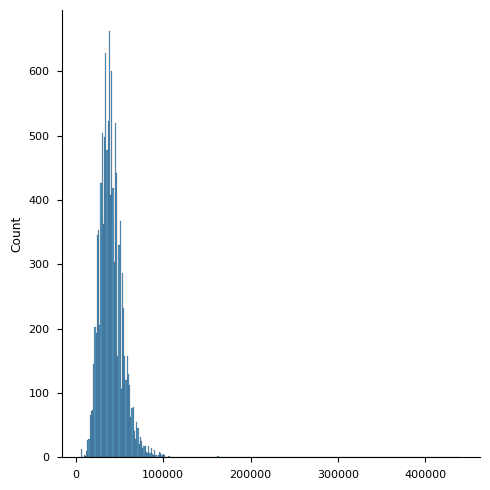

In [8]:
from seaborn import displot

df["data"] = [librosa.effects.trim(data)[0] for data in df["data"]]
displot([len(data) for data in df["data"]])

There are some same which are very long. Now let s plot the amplitude of the audio to see how they are made

In [9]:
def plot_audio_samples(datas, rates = 22050, ax=0):
    for idx in range(0, len(datas), 1000):
        librosa.display.waveshow(datas[idx], sr=rates[idx], alpha=0.5, ax=ax)

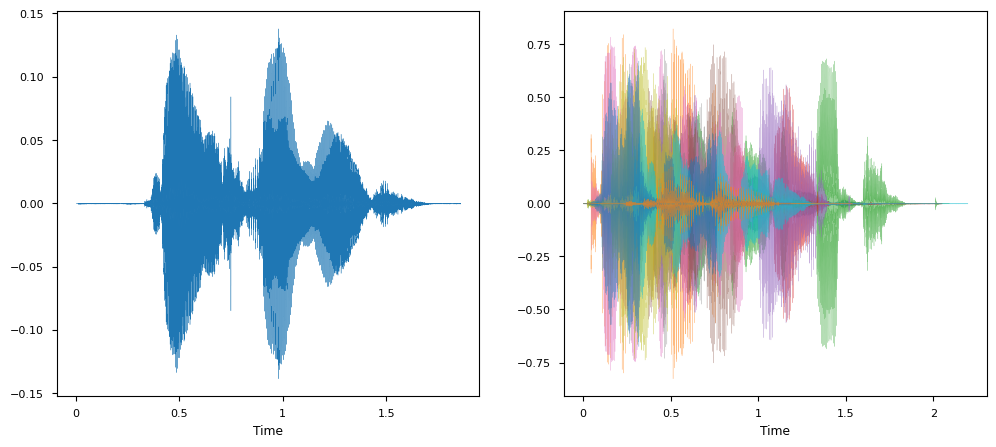

In [10]:
fig, ax = plt.subplots(1, 2, figsize=(12, 5))
librosa.display.waveshow(df["data"][0], sr=df["rate"][0], ax=ax[0])
plot_audio_samples(df["data"], df["rate"], ax=ax[1])

first we can see that the signal could be normalized in order to have each amplitude in the same range.
This is done independently for each sample.

In [11]:
from scipy.stats import zscore

df["data"] = [zscore(data) for data in df["data"]]
# df["data"] = [librosa.util.normalize(data) for data in df["data"]]

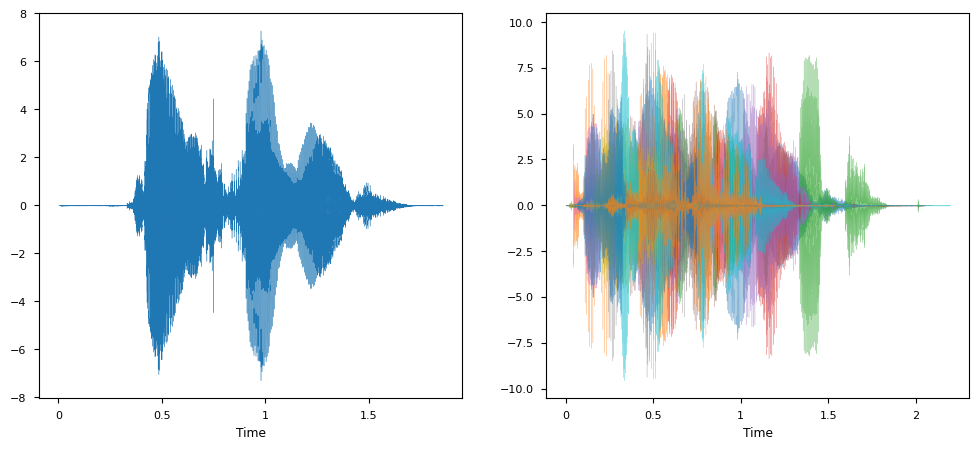

In [12]:
fig, ax = plt.subplots(1, 2, figsize=(12, 5))
librosa.display.waveshow(df["data"][0], sr=df["rate"][0], ax=ax[0])
plot_audio_samples(df["data"], df["rate"], ax=ax[1])

We should pad and cut to have the same length for each audio. Thus, we get the same number of features for each sample.
First, we cut; then we add padding at the end in order to have equal lenght.
We add some  zeros, which represents silence

In [13]:
lengths = [len(data) for data in df["data"]]
perc = 95
desired_length = int(np.ceil(np.percentile(lengths, perc)))
print(f"{desired_length = }")

df["data"] = [data[:desired_length] for data in df["data"]]
df["data"] = [np.pad(data, (0,desired_length-len(data)), constant_values=0.0) for data in df["data"]]

desired_length = 63974


Let's extract the Mel-frequency cepstral coefficients (MFCCs) using the `librosa.feature.mfcc()` function.

In [14]:
# mfccs = [librosa.feature.mfcc(y=data, sr=rate) for data, rate in zip(df["data"], df["rate"])]
# mfccs[0].shape, mfccs[1].shape, mfccs[2].shape

we get the spectogram using the function `librosa.stft`, which stands for Short-time Fourier transform (STFT).
It represents a signal in the time-frequency domain by computing discrete Fourier transforms (DFT) over short overlapping windows.
`n_ftt` is the length of the windowed signal after padding with zeros. The suggested value for speech recognition is 512.

In [15]:
# spects = [librosa.stft(data, n_fft=512) for data in df["data"]]
# spects[0].shape, spects[1].shape, spects[3].shape

Note that, while the first dimension is constant because it refers to the frequency, the second is not. That is because it represents the time.
Therefore, if we would like to sample statistics for boxes of the spectogram, we should add padding to have all the same time length, or change the size of the boxes for each spectogram.

We will use the logarithmic scale on the y axis

In [16]:
# fig, ax = plt.subplots()
# img = librosa.display.specshow(np.abs(spects[0]), x_axis='time', y_axis='log', ax=ax)
# fig.colorbar(img, ax=ax, format="%+2.f dB")

Observe that there are not much infos. Thus it is better to convert the amplitude into decibel. The conversion is logarithmic and reflect the human perception of sounds. Thus, it creates more informative and coherent datas.

In [17]:
# spects_db = [librosa.amplitude_to_db(np.abs(spect), ref=np.max) for spect in spects]
# spects_db[0].shape, spects_db[1].shape, spects_db[3].shape

Same reasonment as before regarding the data shapes.

In [18]:
# fig, ax = plt.subplots()
# img = librosa.display.specshow(spects_db[0], x_axis='time', y_axis='log', ax=ax)
# fig.colorbar(img, ax=ax, format="%+2.0f dB")

Studies have shown that humans do not perceive frequencies on a linear scale. The mel scale have been build to represents how we perceive frequencies. A mel spectrogram is a spectrogram where the frequencies are converted to the mel scale.

In [54]:
mel_spects = [librosa.feature.melspectrogram(y=data, n_fft=512, fmin= 20) for data in df["data"]]
mel_spects_db = [librosa.power_to_db(mel_spect, ref=np.max) for mel_spect in mel_spects]
mel_spects_db[0].shape, mel_spects_db[1].shape, mel_spects_db[3].shape

((128, 125), (128, 125), (128, 125))

In [55]:
mfccs = [librosa.feature.mfcc(S=msdb) for msdb in mel_spects_db]
mean_mfccs = [mfcc.mean(axis=1) for mfcc in mfccs]
mfccs[0].shape, mfccs[1].shape, mfccs[2].shape

((20, 125), (20, 125), (20, 125))

In [82]:
rms = [librosa.feature.rms(y=data)[0] for data in df["data"]]

In [116]:
# Compute the fundamental frequency (F0)
sr = 22050

f0 = [librosa.pitch_tuning(data) for data in df["data"]]


In [128]:
#df["data"] = [librosa.effects.hpss(data)[1] for data in df["data"]]

# Remove high-frequency noise
# df["data"] = [librosa.effects.lowpass(data, sr/2) for data in df["data"]]


# Compute the Linear Prediction Cepstral Coefficients (LPCCs)
# lpccs = [librosa.lpc(y=data, order=12) for data in df["data"]]

KeyboardInterrupt: 

In [127]:
nan = []
for l in lpccs:
    nan.append(np.sum(np.isnan(l)))
print(np.sum(nan))

12


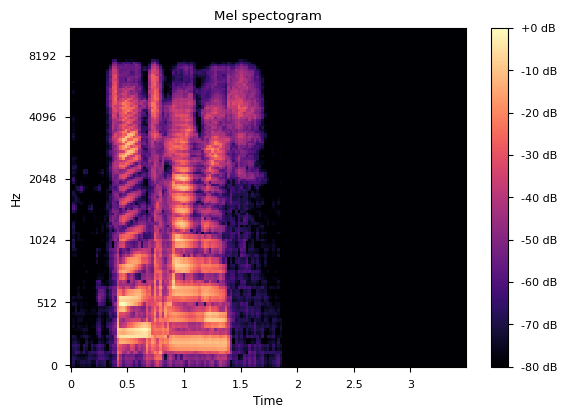

In [81]:
fig, ax = plt.subplots()
img = librosa.display.specshow(mel_spects_db[0], x_axis='time', y_axis='mel', ax=ax)
ax.set(title="Mel spectogram")
fig.colorbar(img, ax=ax, format="%+2.0f dB")

FUNCTIONS FOR DWT PREPROCESSING OF DATA

Let's perform the Discrete Wavelet Transformation(DWT) in order to improve the algorithm performance on recordings with noise.
We'll use the PyWavelet package function 'wavedec' on mel-scaled and log-scaled data to perform the task.

In [62]:
import pywt

# Perform the DWT on the mel-spectrogram
coeffs = [pywt.wavedec(mel_spects_db_elem, 'db4', level=2) for mel_spects_db_elem in mel_spects_db]

# Flatten the DWT coefficients
coeffs = [np.concatenate([coeff.flatten() for coeff in coeffs[i]]) for i in range(len(df))]

## Classify

We decide to drop all the decision variables regarding language because not significant

Since the shapes are all big matrices, we could get some statistical measures from each $n \times m$ box. In particular we have chosen
- mean
- standard deviation
- minimum
- maximum

In [79]:
def compute_statistical_features(matrix, n = 4, m = 10):
    feat = []
    N, M = matrix.shape
    for i in range(0, N, n):
        for j in range(0, M, m):
            feat.append(np.array([
                np.mean(matrix[i:i+n, j:j+m]),
                np.std(matrix[i:i+n, j:j+m]),
                # np.min(matrix[i:i+n, j:j+m]),
                # np.max(matrix[i:i+n, j:j+m])
                ]))
    return np.hstack(feat)

function to test the various model and than the `param_grids` and `models` variables in order to make life easier.

In [20]:
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

def test_model(model, params, X, y, cv=5, scale=False, pca=False, n_components=100):
    # Scale the data if necessary
    if scale:
        scaler = StandardScaler()
        X = scaler.fit_transform(X)
    # Perform PCA if necessary
    if pca:
        pca = PCA(n_components=100)
        X = pca.fit_transform(X)
    # Create a grid search object
    gs = GridSearchCV(model, params, cv=cv, scoring="accuracy")
    # Fit the model
    gs.fit(X, y)
    # Get the best model and score
    best_model = gs.best_estimator_
    best_score = gs.best_score_
    # Return the best model and score
    return gs

function to write the output file

In [21]:
def write_output(df, model, X_eval, type="sklearn", y=None):
    # y is needed for the cnn to get the names of the labels (since it works with one-hot-encoding)
    eval_mask = df["intent"].isna()

    if type == "cnn":
        # predict the class with the maximum probability
        predictions = model.predict(X_eval)
        max_prediction = y.columns[predictions.argmax(axis=1)]
        pd.DataFrame(max_prediction, index=df["Id"][eval_mask]).to_csv("output.csv", index_label="Id", header=["Predicted"])
    else:
        y_pred = model.predict(X_eval)
        pd.DataFrame(y_pred, index=df["Id"][eval_mask]).to_csv("output.csv", index_label="Id", header=["Predicted"])

function that tries the pca and shows the variance explained by it

In [23]:
from sklearn.decomposition import PCA
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler

def try_pca(X, qs = [0.85, 0.90, 0.95]):
    pre = make_pipeline(
        StandardScaler(),
        PCA()
    )
    pca_df_scaled = pre.fit_transform(X)
    fig, ax = plt.subplots(1, 2, figsize=(12, 6))
    evr = pre["pca"].explained_variance_ratio_
    ax[0].bar(range(1,len(evr)+1), evr)
    ax[0].set_xlabel("Principal components")
    ax[0].set_ylabel("Explained variance ratio")
    ax[1].plot(range(1,len(evr)+1), evr.cumsum(), marker="o")
    ax[1].set_xlabel("Principal components")
    ax[1].set_ylabel("Cumulative explained variance ratio")
    ax[1].set_yticks(np.arange(0, 1.1, 0.1))
    plt.tight_layout()
    plt.show()

    zs = []
    for q in qs:
        z = next(x[0] for x in enumerate(evr.cumsum()) if x[1] > q)
        print(f"The {q}% of the data has length lower or equal to {z}.")
        zs.append(z)
    
    return zs

function that builds the dataset

In [50]:
from sklearn.model_selection import train_test_split

def build_datasets(df, feats, cols_to_keep=[], compute_stats=False, n=8, m=10, type="sklearn"):
    if type == "cnn":
        features = np.array(feats)
    else:
        features = []
        for i, f in enumerate(feats):
            if compute_stats[i]:
                features.append(np.vstack([compute_statistical_features(x, n, m) for x in f]))
            else:
                features.append(np.vstack([np.ravel(x) for x in f]))
    features = np.hstack(features)
    if cols_to_keep:
        df_1h = pd.get_dummies(df[cols_to_keep], columns=cols_to_keep)
        X = np.hstack([df_1h.values, features])
    else:
        X = features
    eval_mask = df["intent"].isna()
    X_dev = X[~eval_mask]
    X_eval = X[eval_mask]
    if type == "cnn":
        y = pd.get_dummies(df["intent"][~eval_mask])
    else:
        y = df["intent"][~eval_mask]
    
    return X_dev, y, X_eval

### Convolutional Neural Network

Get the values data set and target values (one hot encoded) which are needed for the cnn.
Note that the cnn discard all the categorical variables. It studies just the image of the mel spectogram to decibel.

In [124]:
X_dev, y, X_eval = build_datasets(df, feats=mel_spects_db, type="cnn")
X_train, X_test, y_train, y_test = train_test_split(X_dev, y, test_size=0.2)

In [125]:
import tensorflow as tf

# define the model
model = tf.keras.Sequential()
model.add(tf.keras.layers.Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=(128, 110, 1)))
model.add(tf.keras.layers.MaxPooling2D(pool_size=(2, 2)))
model.add(tf.keras.layers.Conv2D(64, kernel_size=(3, 3), activation='relu'))
model.add(tf.keras.layers.MaxPooling2D(pool_size=(2, 2)))
model.add(tf.keras.layers.Flatten())
model.add(tf.keras.layers.Dense(128, activation='relu'))
model.add(tf.keras.layers.Dense(32, activation='relu'))
model.add(tf.keras.layers.Dense(7, activation='softmax')) # modify the output layer to have 7 units and softmax activation

# compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# train the model
model.fit(X_train, y_train, epochs=5, validation_data=(X_test, y_test))

Epoch 1/5


ValueError: in user code:

    File "C:\Users\rugli\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py", line 1249, in train_function  *
        return step_function(self, iterator)
    File "C:\Users\rugli\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py", line 1233, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "C:\Users\rugli\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py", line 1222, in run_step  **
        outputs = model.train_step(data)
    File "C:\Users\rugli\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py", line 1023, in train_step
        y_pred = self(x, training=True)
    File "C:\Users\rugli\AppData\Roaming\Python\Python38\site-packages\keras\utils\traceback_utils.py", line 70, in error_handler
        raise e.with_traceback(filtered_tb) from None
    File "C:\Users\rugli\AppData\Roaming\Python\Python38\site-packages\keras\engine\input_spec.py", line 295, in assert_input_compatibility
        raise ValueError(

    ValueError: Input 0 of layer "sequential_1" is incompatible with the layer: expected shape=(None, 128, 110, 1), found shape=(None, 19328)


### Support vector machine

In [132]:
X_dev, y, X_eval = build_datasets(df, feats=[mel_spects_db,mean_mfccs, rms], compute_stats=[True, False, False], n=16, m=5)
X_dev.shape, y.shape, X_eval.shape

((9854, 545), (9854,), (1455, 545))

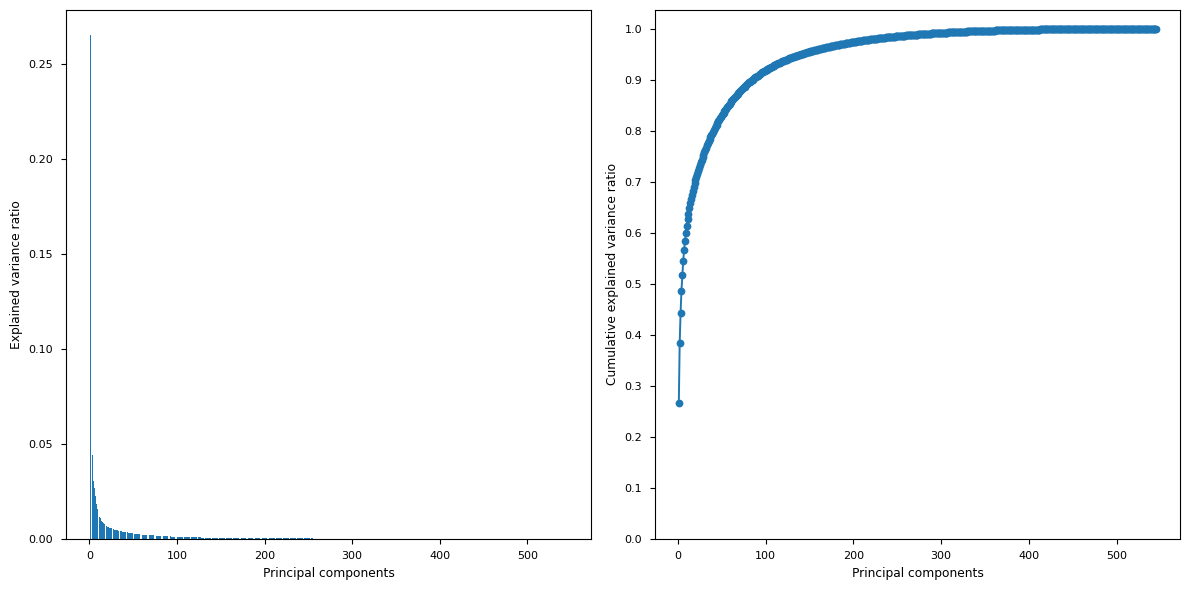

The 0.85% of the data has length lower or equal to 57.
The 0.9% of the data has length lower or equal to 84.
The 0.95% of the data has length lower or equal to 140.


In [133]:
z = try_pca(X_dev)

Support Vector Machine (base and ensemble methods)

In [134]:

from sklearn.svm import SVC

svm_params = {
    "kernel": ['rbf', "poly"],
    "C": [10]
} 

gs = test_model(SVC(), svm_params, X_dev, y, scale=True, pca=True, n_components=z[2])
print(f"""
    {gs.best_estimator_ = }
    {gs.best_score_ = }
""")


    gs.best_estimator_ = SVC(C=10)
    gs.best_score_ = 0.5350051379520819



gs.best_estimator_ = SVC(C=10)

gs.best_score_ = 0.5350051379520819 con trim, statistical fetaures e rms with pca

gs.best_estimator_ = SVC(C=10)

gs.best_score_ = 0.572249083796264

(con trim dei dati e senza compute_statistical_features ma con pca)

da provare senza compute statistical features con pca e aggiungendo rms anche se potrebbe volerci un po'

SVM ensemble method

In [57]:
from sklearn.ensemble import BaggingClassifier
from sklearn.svm import SVC

# Create the base SVM model
svm = SVC(C=10)

ensemble_params = {
    "base_estimator": [svm],
    "n_estimators": [10],
    "bootstrap": [True, False]
}

best_model, best_score = test_model(BaggingClassifier(), ensemble_params, X_dev, y, scale=True, pca=False, n_components=z[1])
print(f"""
    {best_model = }
    {best_score = }
""")

### Tree Classifier

Firstly we'll try to apply the DecisionTreeClassifier method with default parameters in order to check which depth is reached by the tree

In [31]:
from sklearn.tree import DecisionTreeClassifier

clf = DecisionTreeClassifier()
clf.fit(X_dev, y)
clf.tree_.max_depth


28

In [33]:
tree_params = {
    "max_depth": [20, 15, 25],
    "min_impurity_decrease": [0, 0.1, 0.01],
    "max_leaf_nodes" : [200]
}

best_model, best_score = test_model(DecisionTreeClassifier(), tree_params, X_dev, y, scale=True, pca=True, n_components=z[1])
print(f"""
    {best_model = }
    {best_score = }
""")

TypeError: cannot unpack non-iterable GridSearchCV object

### Random forest classifier

In [154]:
mel_spects_db = [x[:,:150] for x in mel_spects_db]
X_dev, y, X_eval = build_datasets(df, feats=mel_spects_db, compute_stats=True, n=8, m=10)

In [135]:
from sklearn.ensemble import RandomForestClassifier

forest_params = {
    "max_depth": [15, 20, 25],
    "n_estimators": [100],
    "criterion": ["gini", "entropy"],
    "n_jobs" : [-1],
    "random_state":[1]
}

gs = test_model(RandomForestClassifier(), forest_params, X_dev, y, scale=True, pca=True, n_components=z[1])
print(f"""
    {gs.best_estimator_ = }
    {gs.best_score_ = }
""")


    gs.best_estimator_ = RandomForestClassifier(criterion='entropy', max_depth=20, n_jobs=-1,
                       random_state=1)
    gs.best_score_ = 0.38664276681938875



### KNN

In [136]:
from sklearn.neighbors import KNeighborsClassifier

knn_params = {"n_neighbors": [ 6, 7, 8],
                'weights': ['uniform', 'distance']}

gs = test_model(KNeighborsClassifier(), knn_params, X_dev, y, scale=True, pca=False)
print(f"""
    {gs.best_estimator_ = }
    {gs.best_score_ = }
    
""")


    gs.best_estimator_ = KNeighborsClassifier(n_neighbors=6, weights='distance')
    gs.best_score_ = 0.4964401074462962
    



gs.best_estimator_ = KNeighborsClassifier(n_neighbors=6, weights='distance') without PCA using mel, mfcc

gs.best_score_ = 0.4905538429048616

gs.best_estimator_ = KNeighborsClassifier(n_neighbors=6, weights='distance') with PCA without compute statistical features

gs.best_score_ = 0.5220135106248729

gs.best_estimator_ = KNeighborsClassifier(n_neighbors=6, weights='distance') with rms, mel, mfcc without pca

gs.best_score_ = 0.4964401074462962

Recurrent Neural Network (not used and fully implemented yet, and I don't want to use it for now)

In [ ]:

import tensorflow as tf
from sklearn.model_selection import GridSearchCV

# Define a function to create the model
def create_model(num_units, activation):
  model = tf.keras.Sequential()
  model.add(tf.keras.layers.LSTM(num_units, input_shape=X_dev.shape[1:]))
  model.add(tf.keras.layers.Dense(7, activation=activation))
  model.compile(loss='categorical_crossentropy',
                optimizer='adam',
                metrics=['accuracy'])
  return model

# Create the model
model = tf.keras.wrappers.scikit_learn.KerasClassifier(build_fn=create_model, epochs=10, batch_size=32)

# Define the hyperparameter search space
param_grid = {'num_units': [32],
              'activation': ['relu']}

# Create the grid search object
grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=3)

# Fit the grid search object to the training data
grid_search.fit(X_dev, y)

# Print the best set of hyperparameters
print("Best hyperparameters:", grid_search.best_params_)
print("Best score:", grid_search.best_score_)

ModuleNotFoundError: No module named 'tensorflow.python'